### This workbook is about building a clusering model for detecting fraudulent activities

* The structure of this workbook:
1. Get the data
2. Analysis
3. Wrangle data
4. Model training

* This workbook is based on the data and tutorial on Datacamp: https://campus.datacamp.com/courses/fraud-detection-in-python/
* I added descriptive analysis, visulization before training the model. I also included more experiments, comparison between models, and detail explanation.

In [6]:
from datetime import datetime
from typing import List, Dict
import re
from typing import List, Tuple

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_curve, \
roc_auc_score, average_precision_score, homogeneity_score, silhouette_score

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN



from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline 

# 1. Get the data

In [7]:
# Import pandas and read csv
df_o = pd.read_csv("./data/chapter_3/banksim.csv")


# 2. Analysis

### (1) Overview of all features

In [8]:
df_o.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 6 columns):
Unnamed: 0    7200 non-null int64
age           7200 non-null object
gender        7200 non-null object
category      7200 non-null object
amount        7200 non-null float64
fraud         7200 non-null int64
dtypes: float64(1), int64(2), object(3)
memory usage: 337.6+ KB


In [9]:
# look at the values in all variables. we can potentially know some values in the categorical variable might need to be adjusted.

for j in range(df_o.shape[1]):
    print(df_o.columns[j])
    print(df_o.iloc[:, j].value_counts())
    print('\n')

Unnamed: 0
591871    1
58614     1
363843    1
294213    1
394993    1
365693    1
308556    1
58702     1
103760    1
296274    1
183635    1
290135    1
589149    1
300384    1
245093    1
548201    1
525674    1
294253    1
372079    1
438074    1
536412    1
347507    1
217323    1
290167    1
256876    1
413051    1
435582    1
114085    1
464192    1
36155     1
         ..
363904    1
424706    1
422463    1
420552    1
461532    1
238281    1
228042    1
131789    1
189787    1
4815      1
584400    1
391890    1
373459    1
314068    1
365555    1
8509      1
443101    1
45819     1
169284    1
76512     1
247514    1
266983    1
37170     1
412396    1
236270    1
557542    1
396020    1
168695    1
436984    1
473385    1
Name: Unnamed: 0, Length: 7200, dtype: int64


age
2    2333
3    1718
4    1279
5     792
1     713
6     314
0      40
U      11
Name: age, dtype: int64


gender
F    3972
M    3212
E      11
U       5
Name: gender, dtype: int64


category
es_transportati

In [10]:
# missing values

def missing_percent(df: pd.DataFrame) -> Dict:
    """Calculate the percentage of the missing data in each columns"""
    percent = {}
    for column_name in list(df.columns):
        percent[column_name] = sum(df[column_name].isnull()) / len(df[column_name])
    return percent

percent = missing_percent(df_o)
percent 

{'Unnamed: 0': 0.0,
 'age': 0.0,
 'gender': 0.0,
 'category': 0.0,
 'amount': 0.0,
 'fraud': 0.0}

### (2) Analyze numerical variables 

In [11]:
df_o.describe()

,Unnamed: 0,amount,fraud
count,7200.000000,7200.000000,7200.000000
mean,296228.038472,36.981587,0.027778
std,172094.972083,40.569355,0.164347
min,13.000000,1.099800,0.000000
25%,145611.250000,14.430000,0.000000
50%,295031.500000,28.020000,0.000000
75%,445221.500000,44.215000,0.000000
max,594622.000000,236.147400,1.000000


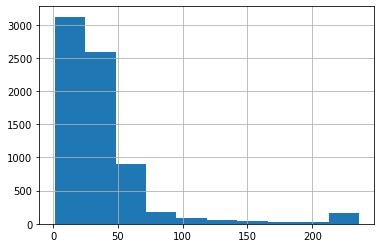

In [12]:
df_o['amount'].hist()

### (3) Analyze categorical variables

In [13]:
df_o.describe(include=[np.object])

,age,gender,category
count,7200,7200,7200
unique,8,4,15
top,2,F,es_transportation
freq,2333,3972,5975


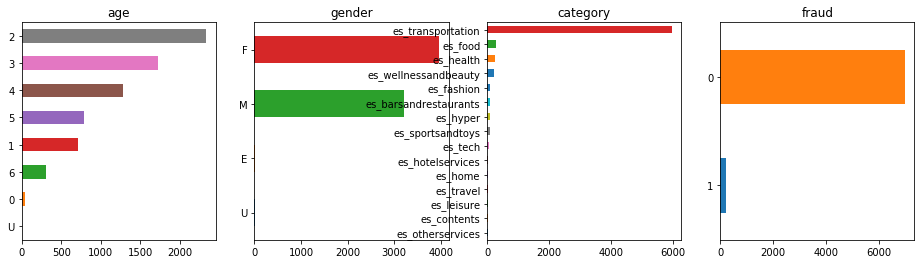

In [14]:
# plot the unique counts for the categorical variables

def plot_categorical(df, categorical_variables_list: List):
    nrows = 1
    ncols = int(np.ceil(len(categorical_variables_list) / nrows))
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4))

    for i in range(len(categorical_variables_list)):
        df.loc[:, categorical_variables_list[i]].value_counts().sort_values(ascending=True).plot.barh(ax=axes[i])
        axes[i].set_title(categorical_variables_list[i])

plot_categorical(df_o, ['age', 'gender', 'category', 'fraud'])


In [15]:
df_o.columns

Index(['Unnamed: 0', 'age', 'gender', 'category', 'amount', 'fraud'], dtype='object')

### (4) Summary

**Which features are available in the dataset?**

 * 'age', 'gender', 'category', 'amount', 'fraud'

 **Which features have missing values?**
 * no missing value

 **What are the numeric variables and categorical variables?**

 * Numerical variables: (1) continuous: 'amount',;
 * Categorial variables: (1) ordinal: none; (2) nominal: 'age', 'gender',  'category', 'fraud'


 **What is the distribution of numerical feature values across the samples?**
 * amount: most people spend less


 **What is the distribution of categorical features?**
 * age: (1)There are three type of age: numeric, 'U'. 'U' mean the age is unknown. Since the number of unknown is very small and I want to treat age as numerical variable, I will remove this 'U' category.  (2) In most of the transactions, the credit card is only used for 2 years. The number of transactions decreases with age increase. Excpet age of 1. This means people are less active with time. 
 
 * Gender: There are 4 genders. There is a gender name 'E', I don't know what it is. The number of E and U is small, I will remove them. most of the trasaction came from women.
 * category: transportation dominate
 * fraud: frauduland is only a small proportion


**Which features are mixed data types?**
 * none

**Which features may contain errors or typos?**


**which feature I should select? preliminary inspection**
 * drop the unname column



### (5) Analyze correlation between features and target


#### (a) Numerical variable vs. target variable

###### amount

In [97]:
df_o.groupby('fraud').mean()

,Unnamed: 0,amount
fraud,,
0,296901.424143,32.662954
1,272659.540000,188.133751


C:\Users\music\AppData\Roaming\Python\Python37\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


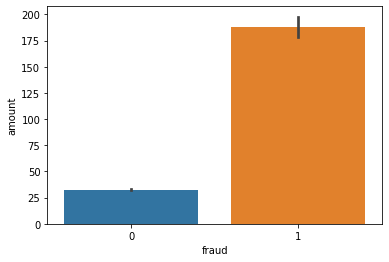

In [18]:
sns.barplot(data=df_o, x='fraud', y='amount')

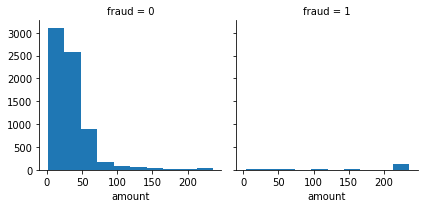

In [23]:
g = sns.FacetGrid(data=df_o, col='fraud')
g.map(plt.hist, 'amount')

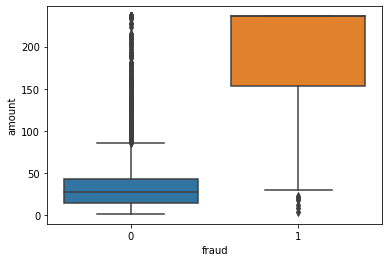

In [68]:
sns.boxplot(data=df_o, x='fraud', y='amount')

##### amount and category

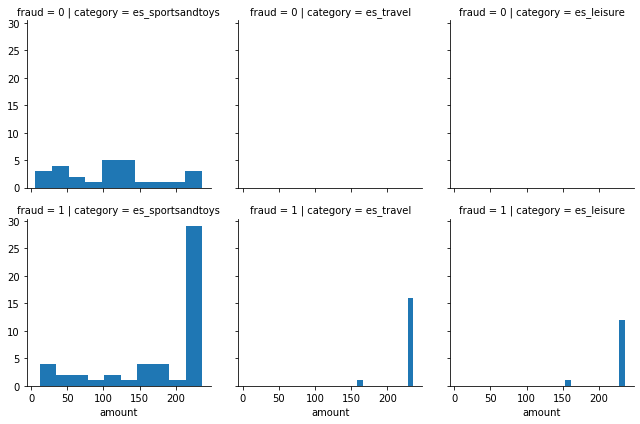

In [60]:
df_temp = df_o.loc[df_o.category.str.contains('es_leisure|es_travel|es_sportsandtoys', regex=True), :]
g = sns.FacetGrid(data=df_temp, col='category', row='fraud')
g.map(plt.hist, 'amount')

**Summary**
* amount vs fraud: In normal activities, the amount in the transaction skew to lower value, while in the fraudulent activities, it is the opposite. amount should be considered into the model.
* Amoung the top tree categories which have highest fraud, sport have more transactions. All categories have large amount in the trasaction. 


####  (b) Categorical variable vs. target variable

###### descriptive

In [19]:
df_o.columns

Index(['Unnamed: 0', 'age', 'gender', 'category', 'amount', 'fraud'], dtype='object')

In [98]:
def cat_target(df, feature, target):
    for i in range(len(feature)):
        print(df.groupby(by=feature[i]).mean().sort_values(by=target, ascending=False), '\n') 

In [99]:
cat_target(df_o, ['age', 'gender', 'category'], 'fraud')

        Unnamed: 0     amount     fraud
age                                    
0    327520.450000  49.468935  0.050000
4    306041.396403  36.197985  0.035966
2    296867.958851  37.228665  0.028718
1    290985.509116  35.622829  0.026648
5    290885.960859  37.547521  0.023990
3    291471.417346  37.279338  0.023283
6    299193.716561  36.700852  0.022293
U    288372.181818  39.117000  0.000000 

           Unnamed: 0     amount     fraud
gender                                    
F       293781.782226  37.842941  0.033484
M       299359.057597  35.918978  0.020859
E       288372.181818  39.117000  0.000000
U       245450.200000  30.644000  0.000000 

                          Unnamed: 0      amount     fraud
category                                                  
es_leisure             186541.307692  229.757600  1.000000
es_travel              338897.777778  231.818656  0.944444
es_sportsandtoys       238775.539474  157.251737  0.657895
es_otherservices       241279.000000  149.6

###### visulization

In [62]:
df_fraud = df_o[df_o['fraud'] == 1]
df_notfraud = df_o[df_o['fraud'] == 0]

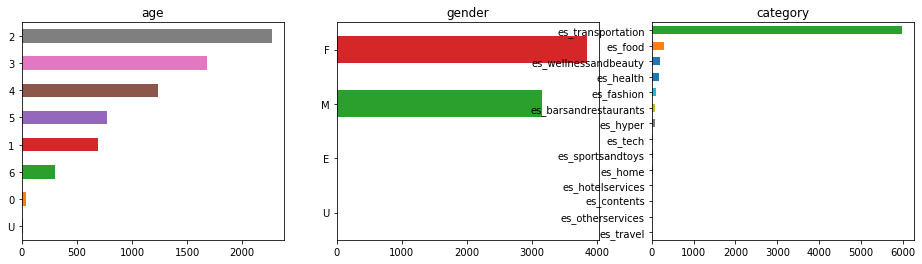

In [63]:
plot_categorical(df_notfraud, [ 'age', 'gender','category'])

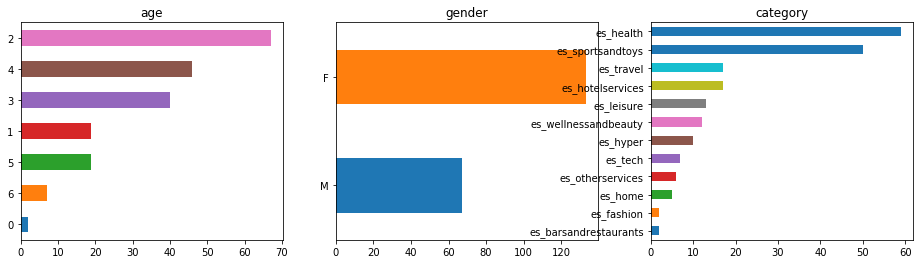

In [64]:
plot_categorical(df_fraud, [ 'age', 'gender','category'])


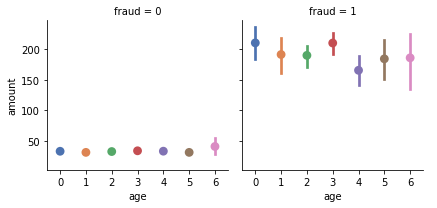

In [95]:
grid = sns.FacetGrid(df_o, col='fraud')
grid.map(sns.pointplot, 'age', 'amount', palette='deep')
grid.add_legend()

**Summary**
* age vs fraud: (1) age 0 has the highest fraudulent probability. This make sense as these people only open the credit card for treating. age 4 is the second highest,  Other age number has similar probability of fraud. (2) The age ranking is different in two group, but it is hard to tell the relationship between age and fraud from the figure. (3) the average amount spent as well as fraud occurrence is rather similar across age groups. Age group '0' stands out but since there are only 40 cases, it does not make sense to split these out in a separate group and run a separate model on them.


* gender: women group has higher fraudulent transaction. From the figure, the number of female is double the number of male in the fraud group, which indicates female tend to fraud in this dataset

* category: leisure, travel, sports are the top 3 categories contain fraudulent activity. Leisure is 100%. some cateogry tend to have more fraud. large amount in the transaction also come from these categories. 


### (6) Assumtions based on data analysis



We arrive at following assumptions based on data analysis done so far. We may validate these assumptions further before taking appropriate actions.

**Correlating.**

We want to know how well does each feature correlate with fraud. We want to do this early in our project and match these quick correlations with modelled correlations later in the project.

**Completing.**

luckily, no missing value

**Correcting.**
 * drop the unname feature
 
**Creating.**
 

**Classifying.**



# 3.  Wrangle data

In [68]:
df = df_o.copy()


###   Drop some columns or remove some categories

In [69]:
df.columns

Index(['Unnamed: 0', 'age', 'gender', 'category', 'amount', 'fraud'], dtype='object')

In [70]:
# remove unkonw column
df.drop(columns=['Unnamed: 0'], inplace=True)

In [106]:
# remove unkonw gender
df = df[~df.gender.str.contains('E|U', regex=True)]

In [104]:
# remove unkonw age
df = df[~df.age.str.contains('U', regex=True)]
df['age'] = df.age.astype(int)

### Converting categorical features

In [110]:
df = pd.get_dummies(df, columns=['gender', 'category'])

check the data again

In [112]:
for j in range(df.shape[1]):
    print(df.columns[j])
    print(df.iloc[:, j].value_counts())
    print('\n')

age
2    2331
3    1717
4    1279
5     792
1     711
6     314
0      40
Name: age, dtype: int64


amount
236.1474    143
1.0998      142
7.5300        8
7.4600        7
35.4700       7
36.1100       6
14.3300       6
8.1400        6
32.7500       6
7.6200        6
10.5900       5
21.9200       5
23.5600       5
19.4100       5
22.0200       5
9.5300        5
14.7900       5
6.6300        5
27.1100       5
28.1500       5
39.9100       5
32.3500       5
41.7600       5
3.2000        5
17.6800       5
7.9900        5
17.3000       5
32.3200       5
14.4500       5
17.8000       5
           ... 
6.6600        1
50.6200       1
82.0600       1
68.3800       1
37.3300       1
45.1800       1
21.7700       1
15.2800       1
24.5700       1
31.3400       1
21.6100       1
33.5100       1
60.7100       1
63.4800       1
50.4300       1
47.7400       1
72.0600       1
48.1700       1
29.1300       1
50.9600       1
58.9200       1
118.5300      1
7.6500        1
23.6000       1
52.5200      

### Scaling the data
For ML algorithms using distance based metrics, it is crucial to always scale your data, as features using different scales will distort your results. K-means uses the Euclidian distance to assess distance to cluster centroids, therefore you first need to scale your data before continuing to implement the algorithm.


In [146]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df)
X_scaled

array([[0.5       , 0.20681002, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.66666667, 0.16247858, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.5       , 0.07513457, 0.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.16666667, 1.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.16666667, 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.66666667, 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ]])

In [149]:
X_scaled.shape

(7184, 20)

In [140]:
y=df.fraud

# 4. Model training

## K-means clustering


### find the elbow

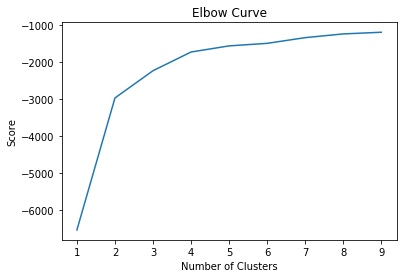

In [164]:
# Define the range of clusters to try
clustno = range(1, 10)

# Run MiniBatch Kmeans over the number of clusters
kmeans = [MiniBatchKMeans(n_clusters=i) for i in clustno]

# Obtain the score for each model
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

# Plot the models and their respective score 
plt.plot(clustno, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

**summary**
* Now you can see that the optimal number of clusters should probably be at around 4 clusters, as that is where the elbow is in the curve. We'll use this in the next exercise as our baseline model, and see how well this does in detecting fraud

###  Detecting outliers 


In [197]:
# Define K-means model 
kmeans = MiniBatchKMeans(n_clusters=4, random_state=42).fit(X_scaled)

#### Obtain predictions and calculate distance from cluster centroid


In [166]:
X_clusters = kmeans.predict(X_scaled)  # for each point , get its corresponding cluster, 0 or 1 or 2 or 3
print(X_clusters)

X_clusters_centers = kmeans.cluster_centers_        # Coordinates of cluster centers.
print(X_clusters_centers.shape)

# for each pooint, calcuate the distance from this point to its corresponding cluster center
dist = [np.linalg.norm(x-y) for x, y in zip(X_scaled, X_clusters_centers[X_clusters])]

# Create fraud predictions based on outliers on clusters 
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0
print(km_y_pred)

[1 3 1 ... 3 3 3]
(4, 20)
[0. 0. 0. ... 1. 1. 0.]


In [167]:
# or we can use this calculation 

diff = X_scaled - X_clusters_centers[X_clusters]
distance = np.linalg.norm(diff, axis=1)
threshold = np.percentile(distance, 95)
km_y_pred = np.where(distance < threshold, 0, 1)

### Checking model results
If you have the label, then evaluate the cluster result


In [169]:
# Obtain the ROC score
print(roc_auc_score(y, km_y_pred))

print(classification_report(y, km_y_pred))

km_cm = confusion_matrix(y, km_y_pred)
print(km_cm)



0.8316781214203894
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      6984
           1       0.39      0.69      0.50       200

    accuracy                           0.96      7184
   macro avg       0.69      0.83      0.74      7184
weighted avg       0.97      0.96      0.97      7184

[[6763  221]
 [  61  139]]


### decrease the percentile

In [171]:
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 85)] = 1
km_y_pred[dist < np.percentile(dist, 85)] = 0

In [172]:
print(roc_auc_score(y, km_y_pred))

print(classification_report(y, km_y_pred))

km_cm = confusion_matrix(y, km_y_pred)
print(km_cm)

0.9371420389461627
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      6984
           1       0.19      1.00      0.31       200

    accuracy                           0.88      7184
   macro avg       0.59      0.94      0.62      7184
weighted avg       0.98      0.88      0.92      7184

[[6106  878]
 [   0  200]]


**summary**
* By lowering the threshold for cases flagged as fraud, you flag more cases overall, recall can be 100%. However, the precistion is very low.

## DB scan

 DBSCAN can handle weirdly shaped data (i.e. non-convex) much better than K-means can. This time, we take the smallest clusters in the data as outlier and label those as fraud. 
 
 
tips: calculate distance to the nearest neighbor
https://github.com/alitouka/spark_dbscan/wiki/Choosing-parameters-of-DBSCAN-algorithm


In [250]:
# Initialize and fit the DBscan model
db = DBSCAN(eps=0.5, min_samples=3, n_jobs=-1).fit(X_scaled) # maximum distance between two samples to 0.9

# Obtain the predicted labels,these are the cluster numbers assigned to an observation.
pred_labels = db.labels_
print(pred_labels)

# calculate number of clusters, ignoring the noise if present.
n_clusters = len(set(pred_labels)) - (1 if -1 in pred_labels else 0) 

print('Estimated number of clusters: %d' % n_clusters)

# Homogeneity metric of a cluster labeling given a ground truth.
print("Homogeneity: %0.3f" % homogeneity_score(y, pred_labels))  
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_scaled, pred_labels))


[ 0  1  0 ... 32 36 31]
Estimated number of clusters: 39
Homogeneity: 0.985
Silhouette Coefficient: 0.787


### Try different min_samples and eps

In [227]:
for min_samples in [5, 10, 20]:
    for eps in [0.1, 0.5, 1]:
        db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1).fit(X_scaled) # maximum distance between two samples to 0.9

        pred_labels = db.labels_
        cluster_sizes = np.bincount(pred_labels[pred_labels>=0])
        print('min_samples ', min_samples, ' eps: ', eps,)
        print('number of clusters:', len(cluster_sizes))
        print('cluster sizes :', cluster_sizes)
        print('\n')


min_samples  5  eps:  0.1
number of clusters: 67
cluster sizes : [ 763  496  840  355 1084  676   63  306  560  134   30   14   25  262
  128  331   15   16    6   28   11   11   22    6    6   12   13   33
   37   14   41   31   11    5    8    5   21    6   10    9   28    8
    7    7    7   18    5   11   13   13   10    4   14    9    5    7
    6    5    6    5    5    5    3   15    8    6    6]


min_samples  5  eps:  0.5
number of clusters: 35
cluster sizes : [3249  104 2714   46  173  119  112   79   52   74    9   43   24   16
   45   42   11   19   13    8    5    7    5   15    8   35    7   10
   40    9    9   19    5   10    6]


min_samples  5  eps:  1
number of clusters: 32
cluster sizes : [3249  144 2714   46  173  119  112   98   52   74    9   43   24   51
   45   42   11   25   19    6    9   13    7    8    6   11    7   10
    9    9    6    6]


min_samples  10  eps:  0.1
number of clusters: 30
cluster sizes : [ 763  496  840  355 1084  676   63  306  560  134 

**Summary**
* number of cluster decreases with min_sample increase or eps increase


### Assessing smallest clusters
without the pri knowledge, true label or human inspection, I don't know which setting I should select. Lets try min_samples=10, eps=0.5

In [251]:
db = DBSCAN(eps=0.5, min_samples=10, n_jobs=-1).fit(X_scaled) # maximum distance between two samples to 0.9

In [252]:
pred_labels = db.labels_

# Count observations in each cluster number
cluster_sizes = np.bincount(pred_labels[pred_labels >= 0])  # bincount can only consider non negative number, we ignore the noise cluster

print('cluster sizes:', cluster_sizes)
print('number of bins is', len(cluster_sizes))

# Sort the sample counts of the clusters and take the top 3 smallest clusters
smallest_clusters = np.argsort(cluster_sizes)[:3]   # ascending order
print("The smallest clusters are clusters:", smallest_clusters)      

# Print the counts of the smallest clusters only
print("Their counts are:", cluster_sizes[smallest_clusters])      

cluster sizes: [3249  104 2714   46  173  119  112   79   52   74   43   24   45   42
   16   13   17   10   15   34   40   19   10]
number of bins is 23
The smallest clusters are clusters: [22 17 15]
Their counts are: [10 10 13]


In [232]:
# Create a dataframe of the predicted cluster numbers and fraud labels 
df = pd.DataFrame({'clusternr':pred_labels,'fraud':y})

# Create a condition flagging fraud for the smallest clusters. 
df['predicted_fraud'] = np.where((df.clusternr == 22)|(df.clusternr == 17)|(df.clusternr == 15), 1 , 0)

# Run a crosstab on the results 
print(pd.crosstab(df.fraud, df.predicted_fraud, rownames=['Actual Fraud'], colnames=['Flagged Fraud']))
print(classification_report(df.fraud, df.predicted_fraud))

Flagged Fraud     0   1
Actual Fraud           
0              6961  23
1               190  10
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      6984
           1       0.30      0.05      0.09       200

    accuracy                           0.97      7184
   macro avg       0.64      0.52      0.54      7184
weighted avg       0.95      0.97      0.96      7184



**Summary**

* The result is not ideal.  out of all flagged cases, only 30% are actually fraud. Since you only take the three smallest clusters, by definition you flag less cases of fraud, so you catch less. However, you are missing quite a lot of fraud cases. 

* If you were to take more of the smallest clusters, you cast your net wider and catch more fraud, but most likely also more false positives. It is up to the fraud analyst to find the right amount of cases to flag and to investigate.

### increase the amount of smallest clusters

In [233]:
# Sort the sample counts of the clusters and take the top 3 smallest clusters
smallest_clusters = np.argsort(counts)[:5]

print("The smallest clusters are clusters:", smallest_clusters)      
print("Their counts are:", counts[smallest_clusters])  


The smallest clusters are clusters: [21 18 24 15 17]
Their counts are: [10 10 11 11 13]


In [237]:
df['predicted_fraud'] = np.where(df.clusternr.isin([21, 18, 24, 15, 17]) ,1 , 0)

print(pd.crosstab(df.fraud, df.predicted_fraud, rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

print(classification_report(df.fraud, df.predicted_fraud))


Flagged Fraud     0   1
Actual Fraud           
0              6961  23
1               166  34
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6984
           1       0.60      0.17      0.26       200

    accuracy                           0.97      7184
   macro avg       0.79      0.58      0.63      7184
weighted avg       0.97      0.97      0.97      7184



**Summary**

* By increasing the number of smallest clusters, both precision and recall are increased. We catch more fraud cases and also decrease the false positive rate. However, if I select the 10 smallest cluster, the precision is 0.38 and the recall is 0.34. precision is increased but recall is decreased

## summary: 

* in the experiments above, Kmean has  higher recall and less precision  than DBSCAN. But it dosen't mean that one is better than the other because 

* (1) we didn't tune the DBSCAN much based on the lable.

* (2) In reality, you often don't have reliable labels and this where a fraud analyst can help you validate the results. He/She can check your results and see whether the cases you flagged are indeed suspicious. You can also check historically known cases of fraud and see whether your model flags them.

# reference

* https://campus.datacamp.com/courses/fraud-detection-in-python/
* Introduction to Machine Learning with Python by Sarah Guido, Andreas C. Müller, Publisher: O'Reilly Media, Inc., Release Date: October 2016, ISBN: 9781449369880
    